<a href="https://colab.research.google.com/github/felkira/unifact.github.io/blob/modeling/dynamic_min_nadam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install keras-tcn to make TCN layer and ipython-autotime to record Each Cell's Execution Time
!pip install keras-tcn
!pip install ipython-autotime
%load_ext autotime

In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import json, re, string, gdown, math, time
from tcn import TCN
from keras.layers import Input, Embedding, Dense, Dropout, SpatialDropout1D, concatenate, GlobalAveragePooling1D, GlobalMaxPooling1D, Bidirectional
from keras.models import Model
from tensorflow.keras.preprocessing import text, sequence
from keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.math import confusion_matrix as cm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report as cr, precision_recall_fscore_support as prfs
from collections import Counter
from random import randint
from google.colab import files

time: 3.27 s (started: 2022-12-12 21:22:28 +00:00)


In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.vec.gz

--2022-12-12 21:22:31--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 172.67.9.4, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1227018698 (1.1G) [binary/octet-stream]
Saving to: ‘cc.id.300.vec.gz’

cc.id.300.vec.gz    100%[===================>]   1.14G  9.00MB/s    in 1m 43s  

2022-12-12 21:24:16 (11.4 MB/s) - ‘cc.id.300.vec.gz’ saved [1227018698/1227018698]

time: 1min 44s (started: 2022-12-12 21:22:31 +00:00)


In [ ]:
!gunzip cc.id.300.vec.gz

time: 30.7 s (started: 2022-12-12 21:24:16 +00:00)


In [ ]:
f = open('/content/cc.id.300.vec', encoding='utf-8')

embedding_vectors = {}
for row in f:
    values = row.split(' ')
    word = values[0]
    weights = np.asarray([float(val) for val in values[1:]])
    embedding_vectors[word] = weights

print(f"Size of vocabulary in FastText: {len(embedding_vectors)}")

Size of vocabulary in FastText: 2000000
time: 2min 20s (started: 2022-12-12 21:24:46 +00:00)


In [ ]:
url = 'https://drive.google.com/u/0/uc?id=1p6hrwRZfgEOrHSQGPdMyZvdi3rQLHS2p&export=download'
gdown.download(url, 'valid-7hoaks.csv', quiet=False)

Downloading...
From: https://drive.google.com/u/0/uc?id=1p6hrwRZfgEOrHSQGPdMyZvdi3rQLHS2p&export=download
To: /content/valid-7hoaks.csv
100%|██████████| 2.07M/2.07M [00:00<00:00, 187MB/s]


'valid-7hoaks.csv'

time: 1.86 s (started: 2022-12-12 21:27:07 +00:00)


In [ ]:
main_data = pd.read_csv('/content/valid-7hoaks.csv')
pd.set_option('max_colwidth', 400)
main_data.head()

,kategori,judul,tanggal,narasi
0,Konten Yang Menyesatkan,buaya meter terbesar di dunia ditemukan di danau kota maine amerika serikat,26/11/2022,buaya meter terbesar dunia ditemukan danau kota maine amerika serikat
1,Konten Yang Salah,demo memprotes kecurangan hasil pemilihan umum di brazil pada november,25/11/2022,demo memprotes kecurangan hasil pemilihan umum brazil november
2,Konten Yang Menyesatkan,warga bogor meninggal hidup kembali,25/11/2022,warga bogor meninggal hidup
3,Konten Yang Menyesatkan,dari fauci akui vaksin tidak melindungi covid,25/11/2022,fauci akui vaksin melindungi covid
4,Konten Yang Menyesatkan,set top box dapat mendeteksi orang yang divaksin,25/11/2022,vaksin gratis set box punah gratis ternyata ternyata dalamnya rangkaian bluetooth low energy device membaca data orang orang yg divaksin aduh


time: 46.1 ms (started: 2022-12-12 21:27:09 +00:00)


In [ ]:
print("Shape of data (rows, cols)=>", main_data.shape)

Shape of data (rows, cols)=> (7530, 4)
time: 466 µs (started: 2022-12-12 21:27:09 +00:00)


In [ ]:
# verify if there is any some null datas
main_data.isnull().sum()

kategori    0
judul       0
tanggal     0
narasi      0
dtype: int64

time: 5.79 ms (started: 2022-12-12 21:27:09 +00:00)


In [ ]:
main_data.describe(include='all')

,kategori,judul,tanggal,narasi
count,7530,7530,7530,7530
unique,8,7530,1317,7528
top,Valid,buaya meter terbesar di dunia ditemukan di danau kota maine amerika serikat,17/10/2022,foto badai petir terlihat luar angkasa
freq,2350,1,87,2


time: 20.9 ms (started: 2022-12-12 21:27:09 +00:00)


In [ ]:
# verify if there is any some duplication
main_data.narasi.duplicated(keep="first").value_counts()

False    7528
True        2
Name: narasi, dtype: int64

time: 4.41 ms (started: 2022-12-12 21:27:09 +00:00)


In [ ]:
# and then, remove the duplicate datas
main_data.drop_duplicates(subset="narasi", keep="first", inplace=True)
main_data.reset_index(drop=True, inplace=True)
main_data.narasi.duplicated(keep="first").value_counts()

False    7528
Name: narasi, dtype: int64

time: 11.9 ms (started: 2022-12-12 21:27:09 +00:00)


In [ ]:
categories = main_data.kategori.unique()
print("Categories:\n", categories)

Categories:
 ['Konten Yang Menyesatkan' 'Konten Yang Salah' 'Satire/Parodi'
 'Konten Palsu' 'Konten Yang Dimanipulasi' 'Konten Tiruan'
 'Koneksi Yang Salah' 'Valid']
time: 1.6 ms (started: 2022-12-12 21:27:09 +00:00)


In [ ]:
main_data.kategori.value_counts()

Valid                       2349
Konten Yang Menyesatkan     1882
Konten Yang Salah           1313
Konten Palsu                 768
Konten Yang Dimanipulasi     643
Konten Tiruan                360
Satire/Parodi                125
Koneksi Yang Salah            88
Name: kategori, dtype: int64

time: 3.62 ms (started: 2022-12-12 21:27:09 +00:00)


In [ ]:
# firstly, I merge some class into new class by the similarity of features
main_data.loc[main_data['kategori'] == 'Konten Yang Salah', 'kategori'] = 'Misleading Content/False Context/Manipulated Content'
main_data.loc[main_data['kategori'] == 'Konten Yang Menyesatkan', 'kategori'] = 'Misleading Content/False Context/Manipulated Content'
main_data.loc[main_data['kategori'] == 'Konten Yang Dimanipulasi', 'kategori'] = 'Misleading Content/False Context/Manipulated Content'

main_data.loc[main_data['kategori'] == 'Konten Palsu', 'kategori'] = 'Fabricated Content/Imposter Content'
main_data.loc[main_data['kategori'] == 'Konten Tiruan', 'kategori'] = 'Fabricated Content/Imposter Content'

main_data = main_data[main_data['kategori'] != 'Koneksi Yang Salah']
main_data = main_data[main_data['kategori'] != 'Satire/Parodi']

main_data.reset_index(drop=True, inplace=True)
main_data.kategori.value_counts()

Misleading Content/False Context/Manipulated Content    3838
Valid                                                   2349
Fabricated Content/Imposter Content                     1128
Name: kategori, dtype: int64

time: 13 ms (started: 2022-12-12 21:27:09 +00:00)


In [ ]:
# I put the narratives dan categories to a new variable first, because the data will be preprocessed after this
XVal, YVal = list(main_data['narasi']), list(main_data['kategori'])

# well, this data will be preprocessed
data = main_data

time: 1.7 ms (started: 2022-12-12 21:27:09 +00:00)


In [ ]:
# let's count the occurrences of word in each sentence
data['words'] = [len(x.split()) for x in data['narasi'].tolist()]
data[['words','narasi']].head()

,words,narasi
0,10,buaya meter terbesar dunia ditemukan danau kota maine amerika serikat
1,8,demo memprotes kecurangan hasil pemilihan umum brazil november
2,4,warga bogor meninggal hidup
3,5,fauci akui vaksin melindungi covid
4,21,vaksin gratis set box punah gratis ternyata ternyata dalamnya rangkaian bluetooth low energy device membaca data orang orang yg divaksin aduh


time: 6.34 ms (started: 2022-12-12 21:27:09 +00:00)


In [ ]:
data['words'].describe()

count    7315.000000
mean       24.798770
std        34.406444
min         2.000000
25%        10.000000
50%        18.000000
75%        27.000000
max      1139.000000
Name: words, dtype: float64

time: 6.32 ms (started: 2022-12-12 21:27:09 +00:00)


In [ ]:
data.groupby(['kategori'])['words'].describe()

,count,mean,std,min,25%,50%,75%,max
kategori,,,,,,,,
Fabricated Content/Imposter Content,1128.0,34.176418,49.519877,3.0,9.0,17.5,41.0,951.0
Misleading Content/False Context/Manipulated Content,3838.0,22.686816,38.396630,2.0,8.0,11.0,22.0,1139.0
Valid,2349.0,23.746275,7.115402,8.0,20.0,23.0,27.0,121.0


time: 19 ms (started: 2022-12-12 21:27:09 +00:00)


In [ ]:
# to balance the data, I just use the datas that the number of its word in range of [3, 200]
data = data[data['words']<=200]
data = data[data['words']>=3]
data.groupby(['kategori'])['words'].describe()

,count,mean,std,min,25%,50%,75%,max
kategori,,,,,,,,
Fabricated Content/Imposter Content,1118.0,31.190519,32.714856,3.0,9.0,17.0,40.75,196.0
Misleading Content/False Context/Manipulated Content,3812.0,20.960913,26.427491,3.0,8.0,11.0,22.00,196.0
Valid,2349.0,23.746275,7.115402,8.0,20.0,23.0,27.00,121.0


time: 17.6 ms (started: 2022-12-12 21:27:09 +00:00)


In [ ]:
# then, I ensure that the amount of data in each class is the same
data[data['kategori']=='Valid'] = data[data['kategori']=='Valid'][1000:2118]
data[data['kategori']=='Misleading Content/False Context/Manipulated Content'] = data[data['kategori']=='Misleading Content/False Context/Manipulated Content'][1000:2118]

data = data.dropna()
data.reset_index(drop=True, inplace=True)
data.groupby(['kategori'])['words'].describe()

,count,mean,std,min,25%,50%,75%,max
kategori,,,,,,,,
Fabricated Content/Imposter Content,1118.0,31.190519,32.714856,3.0,9.0,17.0,40.75,196.0
Misleading Content/False Context/Manipulated Content,1118.0,24.962433,30.107245,3.0,8.0,13.0,28.00,194.0
Valid,1118.0,24.450805,7.682183,11.0,20.0,23.0,27.00,121.0


time: 31.1 ms (started: 2022-12-12 21:27:09 +00:00)


In [ ]:
# let's count the number of occurrences of each word in the dataset
word_freq = data['narasi'].str.split(expand=True).stack().value_counts()
word_freq = word_freq.reset_index(name='freq').rename(columns={'index': 'word'})
word_freq.head(10)

,word,freq
0,indonesia,686
1,orang,486
2,tahun,366
3,negara,319
4,covid,316
5,hari,296
6,jakarta,293
7,tersebut,290
8,yosua,290
9,video,256


time: 7.68 ms (started: 2022-12-12 21:27:09 +00:00)


In [ ]:
print("Number of distinct words in raw data: ", len(list(word_freq['word'])))

Number of distinct words in raw data:  13513
time: 2.34 ms (started: 2022-12-12 21:27:09 +00:00)


In [ ]:
# max_words = len(list(word_freq[word_freq['freq']>=2]['word']))
# i will use the number of distinct words in raw data to make the embedding matrix later
max_words = len(list(word_freq['word']))
# while the highest number of occurrences of data will be used as the sequence padding
max_len = int(data['words'].max())

print(max_words)
print(max_len)

7265
196
time: 4.36 ms (started: 2022-12-12 21:27:09 +00:00)


In [ ]:
# before start to preprocessing, I will shuffle the data first. (this is recommended method in deep learning)
data = data.sample(frac=1)

time: 1.35 ms (started: 2022-12-12 21:27:09 +00:00)


In [ ]:
X, Y = list(data['narasi']), list(data['kategori'])

encoder = LabelEncoder()
Y = to_categorical(encoder.fit_transform(Y), dtype='uint8')

print(Y.shape)
print(encoder.classes_)

(3354, 3)
['Fabricated Content/Imposter Content'
 'Misleading Content/False Context/Manipulated Content' 'Valid']
time: 5.78 ms (started: 2022-12-12 21:27:09 +00:00)


In [ ]:
print(np.argmax(Y, axis=1))

[0 2 0 ... 2 2 2]
time: 1.04 ms (started: 2022-12-12 21:27:09 +00:00)


In [ ]:
def define_report(prediction, test):
  y_pred_class = np.argmax(prediction, axis=1)
  y_class = np.argmax(test, axis=1)
  precision, recall, fscore, support = prfs(y_class, y_pred_class)
  report = cr(y_class, y_pred_class, target_names = encoder.classes_)
  return recall, report

def define_confusion(prediction, test):
  y_pred_class = np.argmax(prediction, axis=1)
  y_class = np.argmax(test, axis=1)
  con_mat = cm(labels=y_class, predictions=y_pred_class).numpy()
  con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=3)
  con_mat_df = pd.DataFrame(con_mat_norm, index = encoder.classes_, columns = encoder.classes_)
  figure = plt.figure(figsize=(13, 10))
  sns.heatmap(con_mat_df, annot=True, fmt='.1%', cmap=plt.cm.Blues)
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

def define_plot(name, param):
  plt.figure(figsize=(15, 7))
  plt.title(name)
  plt.plot(param.history[name], label='train')
  plt.plot(param.history[f'val_{name}'], label='test')
  plt.legend()
  plt.show();

time: 2.24 ms (started: 2022-12-12 21:27:09 +00:00)


# **Embedding Static Fasttext**

In [ ]:
emb_dim = 300
def define_embed(vocabSize, wordId):
  embedding_matrix = np.zeros((vocabSize, emb_dim))
  oov_count = 0
  oov_words = []
  for word, idx in wordId.items():
    if idx < vocabSize:
      embedding_vector = embedding_vectors.get(word)
      if embedding_vector is not None:
        embedding_matrix[idx] = embedding_vector
      else:
        oov_count += 1 
        oov_words.append(word)
  return embedding_matrix

time: 901 µs (started: 2022-12-12 21:27:09 +00:00)


In [ ]:
def define_model(kernel_size, activation, optimizer, input_dim, max_length, output_dim = 300, emb_matrix = None ):
    
    inp = Input( shape=(max_length,))
    x = Embedding(input_dim=input_dim, output_dim=output_dim, input_length=max_length,
                  # Assign the embedding weight with fasttext embedding matrix
                  weights = [emb_matrix],
                  # Set the weight to be trainable (dynamic)
                  trainable = True
                  )(inp)
    x = SpatialDropout1D(0.1)(x)
    
    x = Bidirectional(TCN(64, kernel_size=kernel_size, dilations = [1, 2], return_sequences=True, activation = activation, name = 'tcn1'))(x)
    
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    
    conc = concatenate([avg_pool, max_pool])
    conc = Dropout(0.5)(conc)
    outp = Dense(Y.shape[1], activation="softmax")(conc)   

    model = Model(inputs=inp, outputs=outp)
    model.compile( loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    
    return model

time: 1.4 ms (started: 2022-12-12 21:27:10 +00:00)


In [ ]:
model0_random = define_model(3, 'relu', 'adam', 300, 121, emb_matrix = np.random.rand(300, 300))
model0_random.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 121)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 121, 300)     90000       ['input_1[0][0]']                
                                                                                                  
 spatial_dropout1d (SpatialDrop  (None, 121, 300)    0           ['embedding[0][0]']              
 out1D)                                                                                           
                                                                                                  
 bidirectional (Bidirectional)  (None, 121, 128)     227968      ['spatial_dropout1d[0][0]']  

In [ ]:
# I used large enough combination of parameters, so that I train the model use a for loop approach

trunc_type='post'
padding_type='post'
oov_tok = "<UNK>"
activations = ['tanh', 'relu', 'elu', 'selu', 'swish']
optimizers = ['adam', 'adamax', 'nadam']
kernel_sizes = [2, 3, 4, 5, 6, 7, 8]

columns = ['Optimizer', 'Activation', 'Filters', 'acc1', 'acc2', 'acc3', 'acc4', 'acc5', 'accAVG', 'loss1', 'loss2', 'loss3', 'loss4', 'loss5', 'lossAVG']
record = pd.DataFrame(columns = columns)
kfold = KFold(n_splits=5, shuffle=True)

sentences, labels = X, Y

clouds = [] # this variable will contain the word index of each selected data by k-fold
valid_selected = [] # this variable will contain the word in selected data by k-fold that the data also contained in valid class
false_selected = [] # this variable will contain the word in selected data by k-fold that the data also contained in misleading class
imposter_selected = [] # this variable will contain the word in selected data by k-fold that the data also contained in imposter class
models = [] # this variable will contain the model of each selected data by k-fold
recalls = [] # this variable will contain the recall value of each selected data by k-fold
reports = [] # this variable will contain the classification report of each selected data by k-fold
metas = [] # this variable will contain the y_test data, result, and history of each selected data by k-fold
exp = 0

# I use callback function to stop the training process when the model is stop learning, that is when the loss value is increased
callbacks = EarlyStopping(monitor='val_loss', min_delta=0, patience=4, verbose=2, mode='min', restore_best_weights=True)

for optimizer in optimizers:
  for activation in activations:
    for kernel_size in kernel_sizes:
      exp+=1
      print('--------------------------------------------------------------')
      print('Training {}: {} optimizer, {} activation, {} kernel size.'.format(exp, optimizer, activation, kernel_size))
      print('--------------------------------------------------------------')
      acc_list = []
      loss_list = []
      for train, test in kfold.split(sentences):

        train_x, test_x = [], []
        train_y, test_y = [], []
        
        for i in train:
          train_x.append(sentences[i])
          train_y.append(labels[i])
        for i in test:
          test_x.append(sentences[i])
          test_y.append(labels[i])

        train_valid = []
        train_false = []
        train_imposter = []
        for i in range(len(train_y)):
          label = list(encoder.inverse_transform([np.argmax(train_y[i])]))[0]
          if label == 'Valid':
            for j in train_x[i].split(): train_valid.append(j)
          if label == 'Misleading Content/False Context/Manipulated Content':
            for j in train_x[i].split(): train_false.append(j)
          if label == 'Fabricated Content/Imposter Content':
            for j in train_x[i].split(): train_imposter.append(j)
        
        valid_res = dict(Counter(train_valid))
        false_res = dict(Counter(train_false))
        imposter_res = dict(Counter(train_imposter))
        
        valid_selected.append({k: v for k, v in sorted(valid_res.items(), key=lambda item: item[1], reverse=True)})
        false_selected.append({k: v for k, v in sorted(false_res.items(), key=lambda item: item[1], reverse=True)})
        imposter_selected.append({k: v for k, v in sorted(imposter_res.items(), key=lambda item: item[1], reverse=True)})
        
        train_y = np.array(train_y)
        test_y = np.array(test_y)

        tokenizer = text.Tokenizer(num_words = max_words, oov_token=oov_tok)
        tokenizer.fit_on_texts(train_x)
        training_sequences = tokenizer.texts_to_sequences(train_x)
        test_sequences = tokenizer.texts_to_sequences(test_x)
        Xtrain = sequence.pad_sequences(training_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)
        Xtest = sequence.pad_sequences(test_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

        wordIdx = tokenizer.word_index
        clouds.append(wordIdx)
        vocabSize = len(wordIdx)+1
        embedding_matrix = define_embed(vocabSize, wordIdx)

        model = define_model(kernel_size, activation, optimizer, input_dim=vocabSize, max_length=max_len, emb_matrix=embedding_matrix)
        history = model.fit(Xtrain, train_y, batch_size=50, epochs=100, verbose=0, 
                  callbacks=[callbacks], validation_data=(Xtest, test_y))
        
        loss, acc = model.evaluate(Xtest, test_y, verbose=0)
        print(f'Loss: {loss} - Accuracy: {acc}\n')
        result = model.predict(Xtest)
        recall, report = define_report(result, test_y)
        metas.append([test_y, result, history])
        reports.append(report)
        recalls.append(recall)
        acc_list.append(acc*100)
        loss_list.append(loss)
        models.append(model)
          
      mean_acc = np.array(acc_list).mean()
      mean_loss = np.array(loss_list).mean()
      parameters = [optimizer, activation, kernel_size]
      entries = parameters + acc_list + [mean_acc] + loss_list + [mean_loss]
      temp = pd.DataFrame([entries], columns=columns)
      record = record.append(temp, ignore_index=True)
      print('\n')

In [ ]:
record

,Optimizer,Activation,Filters,acc1,acc2,acc3,acc4,acc5,accAVG,loss1,loss2,loss3,loss4,loss5,lossAVG
0,nadam,tanh,2,84.053653,89.418781,85.394931,84.649777,84.328359,85.569100,0.387835,0.310337,0.361740,0.393732,0.401759,0.371081
1,nadam,tanh,3,85.991061,82.861400,87.779433,86.140090,83.880597,85.330516,0.377276,0.404829,0.332243,0.354499,0.388368,0.371443
2,nadam,tanh,4,84.649777,85.991061,80.476898,87.034279,87.761194,85.182642,0.376450,0.348650,0.412723,0.348817,0.328734,0.363075
3,nadam,tanh,5,84.947836,83.755589,86.289120,85.543966,85.820895,85.271481,0.364636,0.405880,0.362489,0.383296,0.384591,0.380179
4,nadam,tanh,6,87.183309,87.779433,83.755589,87.332338,86.716419,86.553417,0.337520,0.353214,0.404308,0.337417,0.348605,0.356213
5,nadam,tanh,7,85.991061,86.289120,85.991061,86.438149,85.820895,86.106057,0.342299,0.334869,0.353643,0.364088,0.382068,0.355393
6,nadam,tanh,8,84.798807,87.183309,85.842025,88.077497,86.716419,86.523612,0.387585,0.350271,0.368678,0.327746,0.325247,0.351905
7,nadam,relu,2,83.904618,86.438149,87.481374,82.861400,82.686567,84.674422,0.422712,0.350470,0.384354,0.418737,0.417198,0.398694
8,nadam,relu,3,84.798807,84.798807,84.202683,84.053653,85.373133,84.645417,0.402925,0.376144,0.377277,0.362978,0.379056,0.379676
9,nadam,relu,4,86.736214,84.500748,83.755589,85.842025,84.477609,85.062437,0.323884,0.351451,0.389553,0.355271,0.423941,0.368820


time: 21.4 ms (started: 2022-12-12 22:03:52 +00:00)


In [ ]:
record[['Activation', 'accAVG']].groupby(by='Activation').max().sort_values(by='accAVG', ascending=False)

,accAVG
Activation,
relu,86.792313
tanh,86.553417
swish,86.285473
selu,85.926553
elu,85.778588


time: 13.6 ms (started: 2022-12-12 22:03:52 +00:00)


In [ ]:
record[['Activation', 'lossAVG']].groupby(by='Activation').min().sort_values(by='lossAVG', ascending=True)

,lossAVG
Activation,
relu,0.345706
tanh,0.351905
selu,0.353853
elu,0.359851
swish,0.366640


time: 6.86 ms (started: 2022-12-12 22:03:52 +00:00)


In [ ]:
max_recall_0 = [i[0] for i in recalls]
max_recall_0_idx = [i for i in range(len(max_recall_0)) if max_recall_0[i] >= .8]
print(*max_recall_0_idx, sep=', ')

0, 1, 6, 10, 11, 15, 20, 23, 25, 38, 42, 43, 45, 53, 58, 61, 65, 66, 67, 71, 72, 75, 80, 84, 85, 93, 98, 102, 109, 110, 111, 112, 116, 122, 125, 127, 132, 137, 140, 148, 149, 153, 159, 166, 170, 173
time: 2.52 ms (started: 2022-12-12 22:03:52 +00:00)


In [ ]:
recall_filtered = [m for m in [[i, rec[1]] for i, rec in enumerate(recalls) if i in max_recall_0_idx] if m[1] >= .8]

print(recall_filtered)

[[1, 0.8666666666666667], [11, 0.8140495867768595], [20, 0.8590909090909091], [23, 0.8713692946058091], [45, 0.8018867924528302], [53, 0.8316831683168316], [61, 0.8127853881278538], [66, 0.8347826086956521], [71, 0.8480392156862745], [72, 0.825531914893617], [102, 0.8189655172413793], [110, 0.8292682926829268], [111, 0.8393574297188755], [112, 0.8018867924528302], [127, 0.8211009174311926], [137, 0.8133971291866029], [159, 0.8831168831168831], [166, 0.8212765957446808], [173, 0.8243243243243243]]
time: 1.37 ms (started: 2022-12-12 22:03:52 +00:00)


In [ ]:
for i in range(len(recall_filtered)):
  print(reports[recall_filtered[i][0]], '\n\n')

                                                      precision    recall  f1-score   support

                 Fabricated Content/Imposter Content       0.87      0.83      0.85       218
Misleading Content/False Context/Manipulated Content       0.84      0.87      0.86       225
                                               Valid       0.97      0.99      0.98       228

                                            accuracy                           0.89       671
                                           macro avg       0.89      0.89      0.89       671
                                        weighted avg       0.89      0.89      0.89       671
 


                                                      precision    recall  f1-score   support

                 Fabricated Content/Imposter Content       0.80      0.82      0.81       206
Misleading Content/False Context/Manipulated Content       0.83      0.81      0.82       242
                                               Valid 

In [ ]:
bests = [0, 2, 3, 4, 8, 10, 12, 14, 16, 17, 18]
selecteds = [recall_filtered[i][0] for i in bests]

time: 858 µs (started: 2022-12-12 22:10:49 +00:00)


In [ ]:
def tokenize(text, cloud):
  s = text.split()
  return [cloud[s[i]] if s[i] in cloud else 1 for i in range(len(s))]

def pad_sequence(seq):
  return [0 if i < (max_len - len(seq)) else seq[i - (max_len - len(seq))] for i in range(max_len)]

time: 4.11 ms (started: 2022-12-12 22:10:49 +00:00)


In [ ]:
results = []

for j in selecteds:
  predict_temp = []
  false_temp = []
  print(f'model-{j} predict')
  for i in range(len(XVal)):
    seq = tokenize(XVal[i], clouds[j])
    padded = np.array([pad_sequence(seq)])
    preds = models[j].predict(padded)
    proba = preds[0].tolist()
    classes = list(encoder.classes_)
    prediction = classes[proba.index(max(preds[0]))]
    if prediction == YVal[i]: predict_temp.append(True)
    else: false_temp.append(classes.index(YVal[i]))

  results.append(f'correct: {len(predict_temp)}/{len(XVal)}: {round(len(predict_temp)/len(XVal) * 100, 3)}%  -  false-i: {false_temp.count(0)}  -  false-m: {false_temp.count(1)}  -  false-v: {false_temp.count(2)}')

In [ ]:
for i in range(len(selecteds)):
  print('model:', selecteds[i], f'\n{results[i]}')

model: 1 
correct: 6314/7315: 86.316%  -  false-i: 129  -  false-m: 822  -  false-v: 50
model: 20 
correct: 5452/7315: 74.532%  -  false-i: 126  -  false-m: 1655  -  false-v: 82
model: 23 
correct: 6439/7315: 88.025%  -  false-i: 143  -  false-m: 562  -  false-v: 171
model: 45 
correct: 5976/7315: 81.695%  -  false-i: 98  -  false-m: 1180  -  false-v: 61
model: 71 
correct: 6203/7315: 84.798%  -  false-i: 116  -  false-m: 897  -  false-v: 99
model: 102 
correct: 5838/7315: 79.809%  -  false-i: 164  -  false-m: 686  -  false-v: 627
model: 111 
correct: 6287/7315: 85.947%  -  false-i: 194  -  false-m: 791  -  false-v: 43
model: 127 
correct: 6129/7315: 83.787%  -  false-i: 275  -  false-m: 831  -  false-v: 80
model: 159 
correct: 6291/7315: 86.001%  -  false-i: 188  -  false-m: 641  -  false-v: 195
model: 166 
correct: 5938/7315: 81.176%  -  false-i: 119  -  false-m: 1051  -  false-v: 207
model: 173 
correct: 4759/7315: 65.058%  -  false-i: 172  -  false-m: 632  -  false-v: 1752
time: 1.

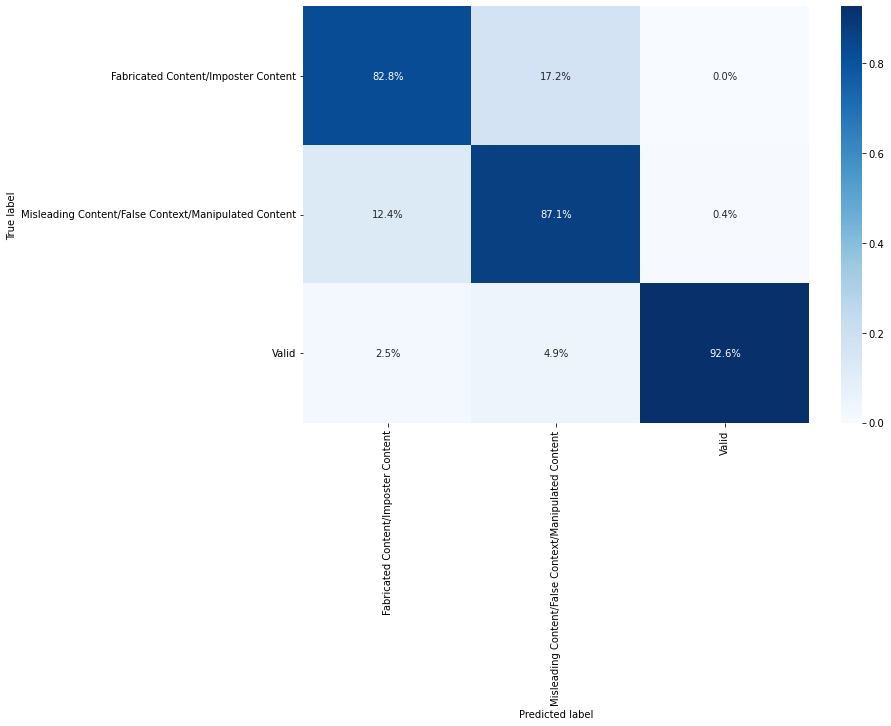

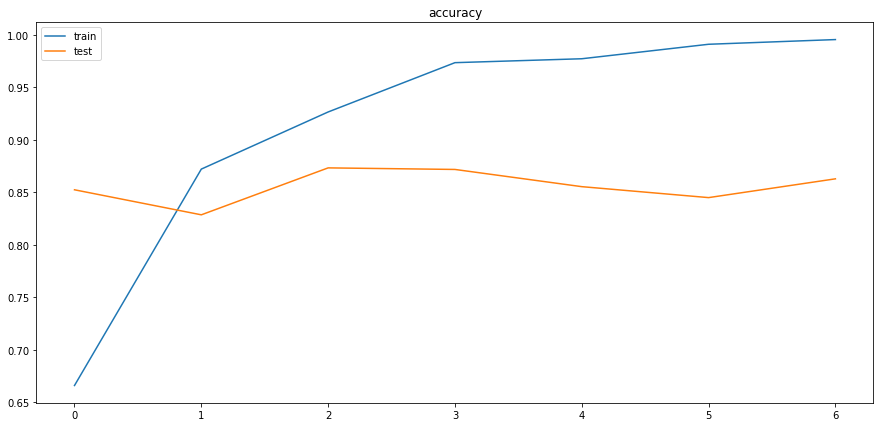

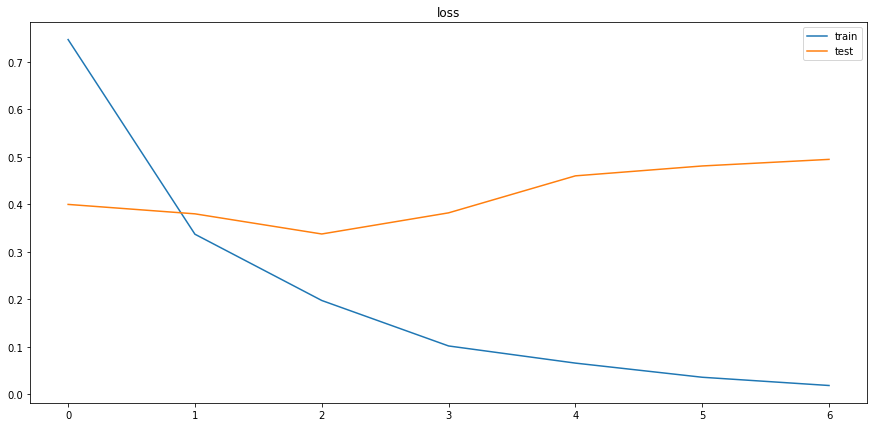




time: 667 ms (started: 2022-12-12 23:23:01 +00:00)


In [ ]:
best = [23, 6439]
define_confusion(metas[best[0]][2], metas[best[0]][1])
print('\n')
define_plot('accuracy', metas[best[0]][3])
print('\n')
define_plot('loss', metas[best[0]][3])
print('\n\n')

In [ ]:
record.to_excel('acc_loss_records.xlsx', index=False, encoding='utf-8')

time: 216 ms (started: 2022-12-12 23:23:01 +00:00)


In [ ]:
def cr_to_excel(report, index, score):
    report_data = []
    lines = report.split('\n')
    for line in (lines[2:5]+lines[7:9]):
        row = {}
        row_data = line.split()
        row['class'] = ' '.join(row_data[0:-4])
        row['precision'] = row_data[-4]
        row['recall'] = row_data[-3]
        row['f1_score'] = row_data[-2]
        row['support'] = row_data[-1]
        row['accuracy'] = round(record.iloc[math.ceil((index+0.5)/5) - 1][f'acc{(index%5) + 1}'], 2)
        row['loss'] = round(record.iloc[math.ceil((index+0.5)/5) - 1][f'loss{(index%5) + 1}'], 4)
        row['activation'] = record.iloc[math.ceil((index+0.5)/5) - 1]['Activation']
        row['optimizer'] = record.iloc[math.ceil((index+0.5)/5) - 1]['Optimizer']
        row['kernel'] = record.iloc[math.ceil((index+0.5)/5) - 1]['Filters']
        row['test_score'] = round((score/len(XVal)*100), 2)
        report_data.append(row)
    dataframe = pd.DataFrame.from_dict(report_data)
    dataframe.to_excel(f'classification_report-{index}.xlsx', index = False)

cr_to_excel(reports[best[0]], best[0], best[1])

time: 16.7 ms (started: 2022-12-12 23:23:01 +00:00)


In [ ]:
def clouds_to_json(index):
  with open(f'word_dict-{index}.json' , 'w') as file:    
    json.dump(clouds[index], file)

clouds_to_json(best[0])

time: 15.1 ms (started: 2022-12-12 23:23:02 +00:00)


In [ ]:
def res_to_json(index):
  with open(f'residu-{index}.json' , 'w') as file:    
    json.dump({'valid': valid_selected[index], 'false': false_selected[index], 'imposter': imposter_selected[index]}, file)

res_to_json(best[0])

time: 21.7 ms (started: 2022-12-12 23:23:02 +00:00)


In [ ]:
models[best[0]].save(f"model-{best[0]}.h5")

time: 148 ms (started: 2022-12-12 23:23:02 +00:00)


In [ ]:
files.download('acc_loss_records.xlsx')

files.download(f'classification_report-{best[0]}.xlsx')
files.download(f'word_dict-{best[0]}.json')
files.download(f'residu-{best[0]}.json')
files.download(f'model-{best[0]}.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

time: 22.7 ms (started: 2022-12-12 23:23:02 +00:00)
